To find an appropriate cutoff of prediction probability to establish the ground truth homozygous TEI sites, we binned the prediction probability by intervals of $0.1$ from $0$ to $1$ and calculate the prediction accuracy/balanced prediction accuracy in each bin. Once we find an appropriate cutoff of prediction probability, we will run xTea-ML on all the benchmarking ancient samples to find the features from TEI +/+ and TEI -/- (defined as very very low probability of having an insertion) individuals and then down-sample and mix the two bam files to generate the heterozygous TEI features for model training, validation, and testing.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split

import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)

from sklearn.metrics import balanced_accuracy_score, confusion_matrix, classification_report
from time import time

In [2]:
def clean_test_data(input_file, header=True):
    test_df = pd.read_csv(input_file, sep="\t")
    if not header:
        test_df.columns = ["#chr", "pos", "TE_chr", "TE_start", "TE_end", "TE_family", "TE_length",
                           "nearby_sites",
                           "lclip", "rclip",
                           "cr_Alu", "cr_L1", "cr_SVA",
                           "cns_Alu", "cns_L1", "cns_SVA",
                           "raw_ldisc", "raw_rdisc", 
                           "ldisc_Alu", "rdisc_Alu", "ldisc_L1", "rdisc_L1", "ldisc_SVA", "rdisc_SVA",
                           "ratio_lcluster", "ratio_rcluster",
                           "dr_Alu", "dr_L1", "dr_SVA",
                           "longest_clip_len", "l_cov", "r_cov", "polyA", "cns_std_l_polyA", "cns_std_r_polyA", "ratio_low_MAPQ", "clip_pos_std"]
    else:
        test_df.rename(columns={"15": "TE_start"}, inplace=True)
    test_df = test_df.replace({'TE_family': '.'}, {'TE_family': "FP"}, regex=False)
    test_df = test_df.replace(regex=r'^SINE/Alu.*$', value='Alu')
    test_df = test_df.replace(regex=r'^LINE/L1.*$', value='L1')
    test_df = test_df.replace(regex=r'^Retroposon/SVA.*$', value='SVA')
    test_df = test_df.drop(["#chr", "pos", "TE_chr", "TE_start", "TE_end", "TE_length"], axis=1)
    test_features_norm = test_df.drop(['lclip', 'rclip', 'cr_Alu', 'cns_Alu', 'cr_L1', 'cns_L1', 'cr_SVA', 'cns_SVA', 
                             'raw_ldisc', 'raw_rdisc', 
                             'ldisc_Alu', 'rdisc_Alu', 'dr_Alu', 'ldisc_L1', 'rdisc_L1', 'dr_L1','ldisc_SVA', 'rdisc_SVA', 'dr_SVA',
                             'l_cov', 'r_cov', 'polyA', 'cns_std_l_polyA', 'cns_std_r_polyA'], axis=1)
    test_labels = test_df['TE_family']
    test_features_norm['lclip'] = np.where(test_df['l_cov']>0, test_df['lclip']/test_df['l_cov'], 0)
    test_features_norm['rclip'] = np.where(test_df['r_cov']>0, test_df['rclip']/test_df['r_cov'], 0)
    test_features_norm['cr_Alu'] = np.where(test_df['lclip']+test_df['rclip']>0, test_df['cr_Alu']/(test_df['lclip']+test_df['rclip']), 0)
    test_features_norm['cns_Alu'] = np.where(test_df['lclip']+test_df['rclip']>0, test_df['cns_Alu']/(test_df['lclip']+test_df['rclip']), 0)
    test_features_norm['cr_L1'] = np.where(test_df['lclip']+test_df['rclip']>0, test_df['cr_L1']/(test_df['lclip']+test_df['rclip']), 0)
    test_features_norm['cns_L1'] = np.where(test_df['lclip']+test_df['rclip']>0, test_df['cns_L1']/(test_df['lclip']+test_df['rclip']), 0)
    test_features_norm['cr_SVA'] = np.where(test_df['lclip']+test_df['rclip']>0, test_df['cr_SVA']/(test_df['lclip']+test_df['rclip']), 0)
    test_features_norm['cns_SVA'] = np.where(test_df['lclip']+test_df['rclip']>0, test_df['cns_SVA']/(test_df['lclip']+test_df['rclip']), 0)
    test_features_norm['ldisc_Alu'] = np.where(test_df['r_cov']>0, test_df['ldisc_Alu']/test_df['r_cov'], 0)
    test_features_norm['rdisc_Alu'] = np.where(test_df['l_cov']>0, test_df['rdisc_Alu']/test_df['l_cov'], 0)
    test_features_norm['ldisc_L1'] = np.where(test_df['r_cov']>0, test_df['ldisc_L1']/test_df['r_cov'], 0)
    test_features_norm['rdisc_L1'] = np.where(test_df['l_cov']>0, test_df['rdisc_L1']/test_df['l_cov'], 0)
    test_features_norm['ldisc_SVA'] = np.where(test_df['r_cov']>0, test_df['ldisc_SVA']/test_df['r_cov'], 0)
    test_features_norm['rdisc_SVA'] = np.where(test_df['l_cov']>0, test_df['rdisc_SVA']/test_df['l_cov'], 0)
    test_features_norm['dr_Alu'] = np.where(test_df['raw_ldisc']+test_df['raw_rdisc']>0, test_df['dr_Alu']/(test_df['raw_ldisc']+test_df['raw_rdisc']), 0)
    test_features_norm['dr_L1'] = np.where(test_df['raw_ldisc']+test_df['raw_rdisc']>0, test_df['dr_L1']/(test_df['raw_ldisc']+test_df['raw_rdisc']), 0)
    test_features_norm['dr_SVA'] = np.where(test_df['raw_ldisc']+test_df['raw_rdisc']>0, test_df['dr_SVA']/(test_df['raw_ldisc']+test_df['raw_rdisc']), 0)
    test_features_norm['cns_std_l_polyA'] = np.where(test_df['l_cov']>0, test_df['cns_std_l_polyA']/test_df['l_cov'], 0)
    test_features_norm['cns_std_r_polyA'] = np.where(test_df['r_cov']>0, test_df['cns_std_r_polyA']/test_df['r_cov'], 0)
    test_features = test_features_norm.drop('TE_family', axis=1)
    
    return test_features, test_labels

In [3]:
test_features, test_labels = clean_test_data("./data/all_chr2.impute.out")

In [4]:
models = {}
mdl = 'GB'
models[mdl] = joblib.load('./models/all_{}_model.pkl'.format(mdl))

In [58]:
def determine_pred_prob(s):
    if s['pred'] == 'Alu':
        return s['Alu_prob']
    elif s['pred'] == 'L1':
        return s['L1_prob']
    elif s['pred'] == 'SVA':
        return s['SVA_prob']
    else:
        return s['FP_prob']

def get_pred_prob(name, model, features, labels):
    pred = model.predict(features)
    pred_prob = pd.DataFrame(model.predict_proba(features),columns=['Alu_prob','FP_prob','L1_prob','SVA_prob'])
    df1 = pd.DataFrame(np.concatenate((np.asarray(labels).reshape(-1,1), np.asarray(pred).reshape(-1,1)), axis=1), 
                       columns=['labels', 'pred'])
    df = pd.concat([df1, pred_prob], axis=1)
    df['correct'] = np.where(df['labels']==df['pred'], 1, 0)
    df['pred_prob'] = df.apply(determine_pred_prob, axis=1)
    df = df.drop(['Alu_prob', 'FP_prob', 'L1_prob', 'SVA_prob'], axis=1)
    Alu_df = df[df['pred']=='Alu']
    L1_df = df[df['pred']=='L1']
    SVA_df = df[df['pred']=='SVA']
    FP_df = df[df['pred']=='FP']
    return df, Alu_df, L1_df, SVA_df, FP_df

In [59]:
for name, mdl in models.items():
    df, Alu_df, L1_df, SVA_df, FP_df = get_pred_prob(name, mdl, test_features, test_labels)

In [106]:
def calc_binned_accuracy(df):
    bins = list(np.arange(0, 1.1, 0.1))
    labels = list(np.arange(0.1, 1.1, 0.1))
    df['binned_pred_prob'] = pd.cut(df['pred_prob'], bins=bins, labels=labels)
    df_grouped = df.groupby('binned_pred_prob').correct.mean().reset_index()
    return df_grouped.correct

In [107]:
all_mean = calc_binned_accuracy(df)
Alu_mean = calc_binned_accuracy(Alu_df)
L1_mean = calc_binned_accuracy(L1_df)
SVA_mean = calc_binned_accuracy(SVA_df)
FP_mean = calc_binned_accuracy(FP_df)
count_df = pd.concat([all_mean, Alu_mean, L1_mean, SVA_mean, FP_mean], axis=1)
count_df = count_df.fillna(0)
count_df.columns = ['all', 'Alu', 'L1', 'SVA', 'FP']
count_df.index = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]


c:\users\97841\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


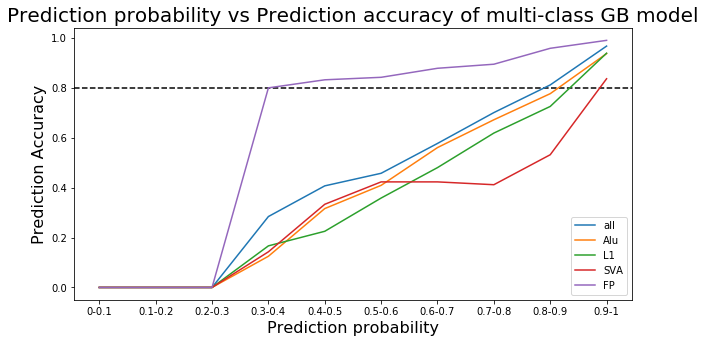

In [110]:
fig, axes = plt.subplots(1, 1, figsize=(10, 5))
axes.axhline(y = 0.8, color="black", xmin = 0, xmax = 1.0, linestyle='dashed')
count_df.plot.line(ax=axes)
axes.set_xlabel("Prediction probability", fontsize=16)
axes.set_ylabel("Prediction Accuracy", fontsize=16)
axes.set_xticks([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
axes.set_xticklabels(['0-0.1','0.1-0.2','0.2-0.3','0.3-0.4','0.4-0.5','0.5-0.6','0.6-0.7','0.7-0.8','0.8-0.9','0.9-1'])
axes.set_title("Prediction probability vs Prediction accuracy of multi-class GB model", fontsize=20)
plt.savefig('multi_class_GB_pred_prob_vs_accuracy.png')